Running standard rank preservation test...
Plotting standard test results...


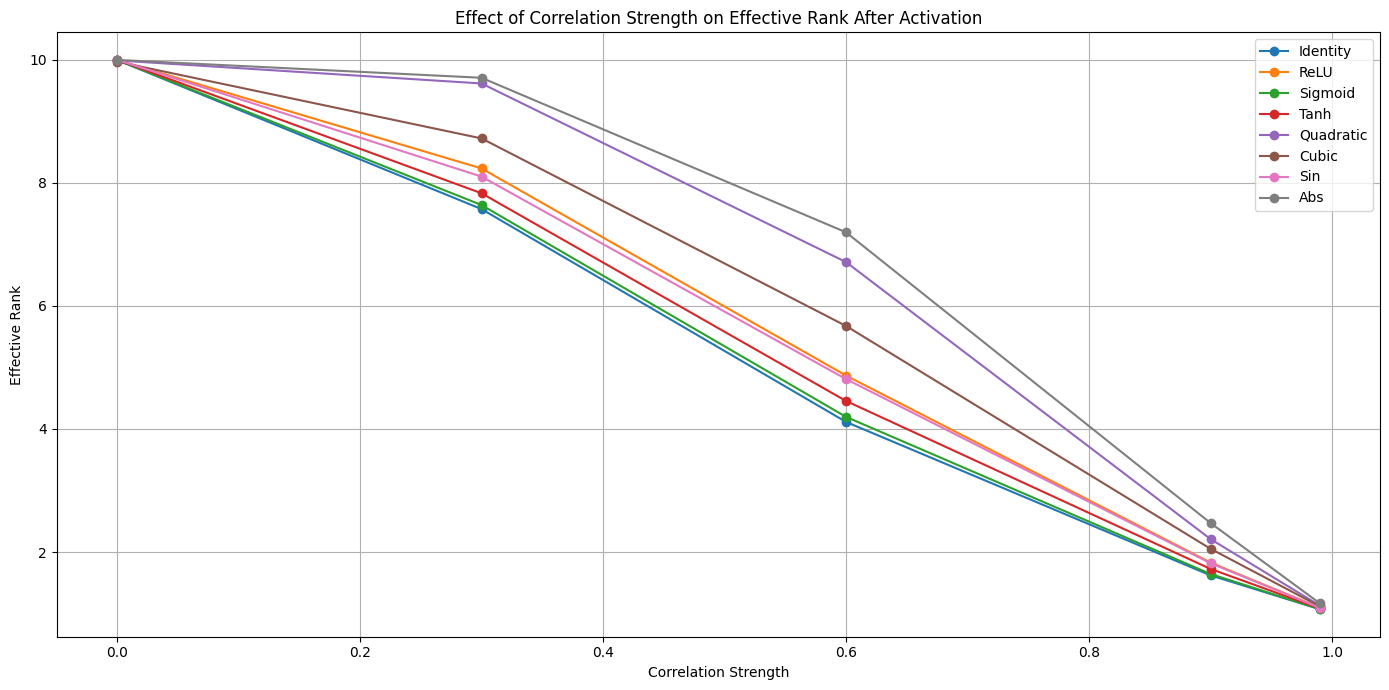

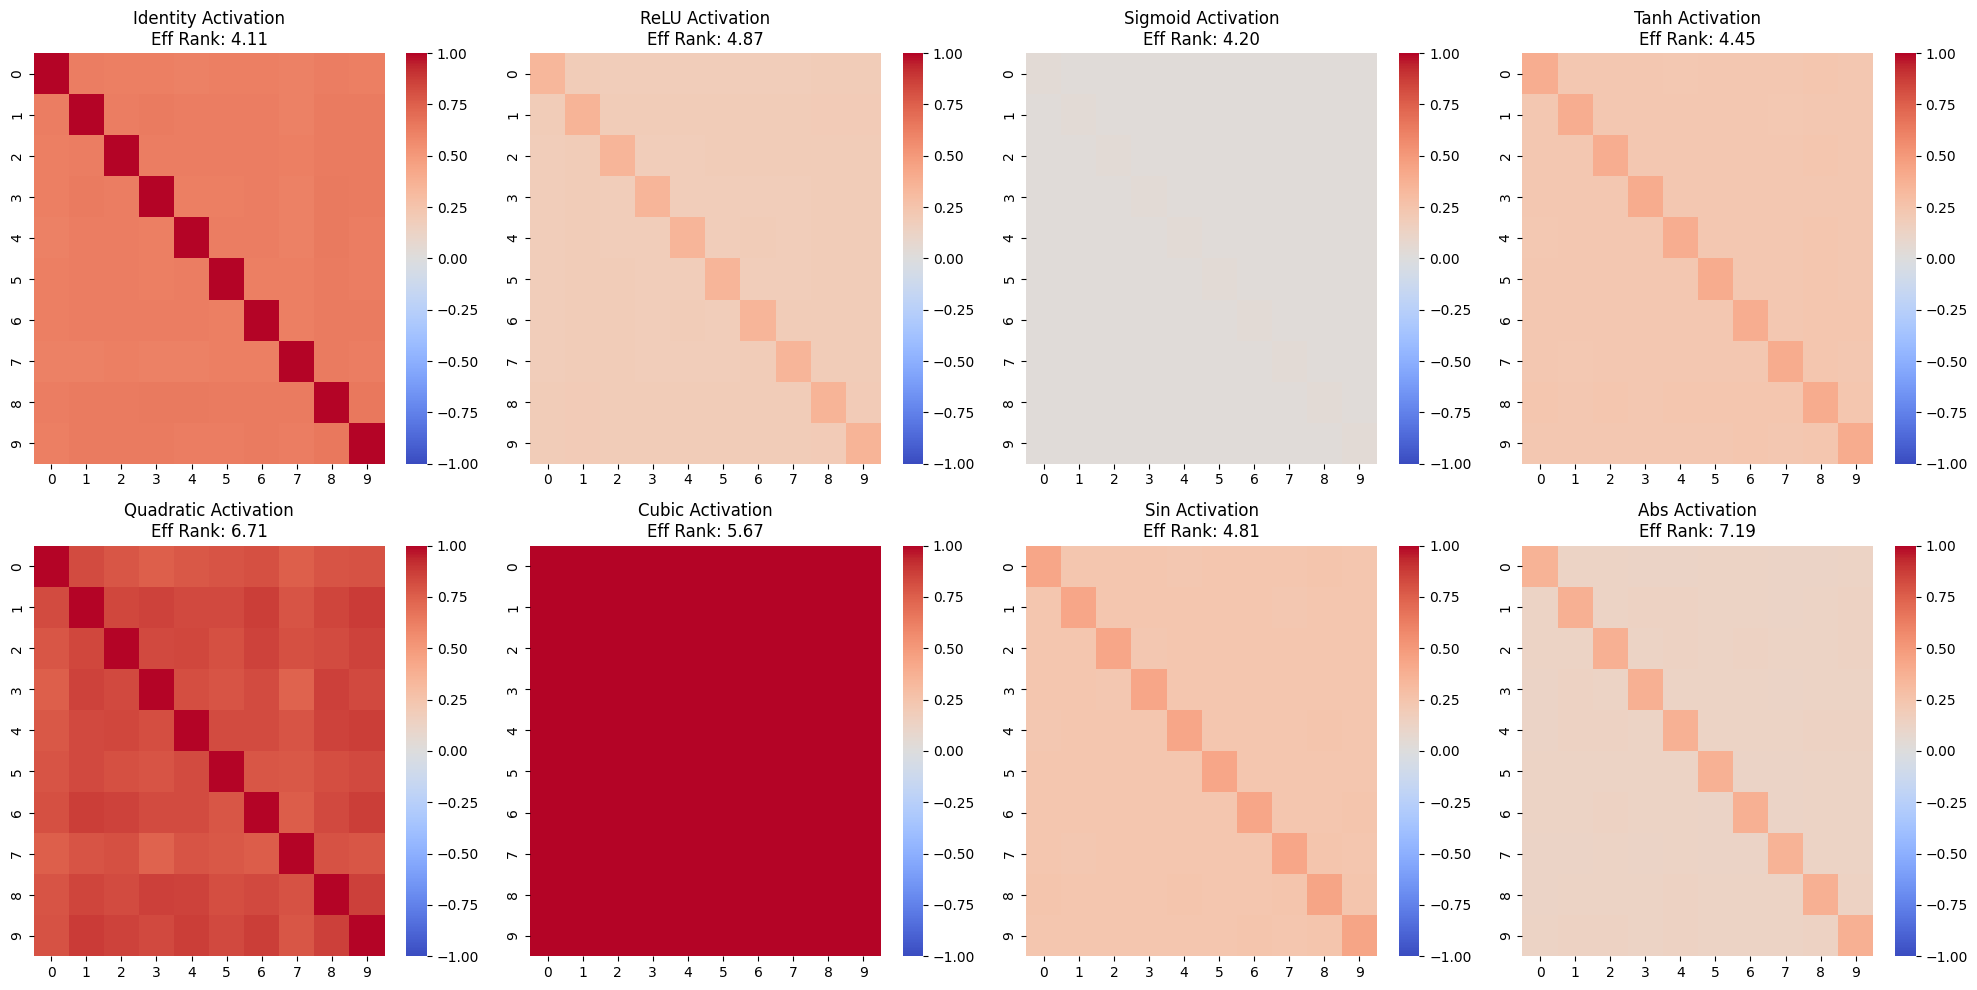

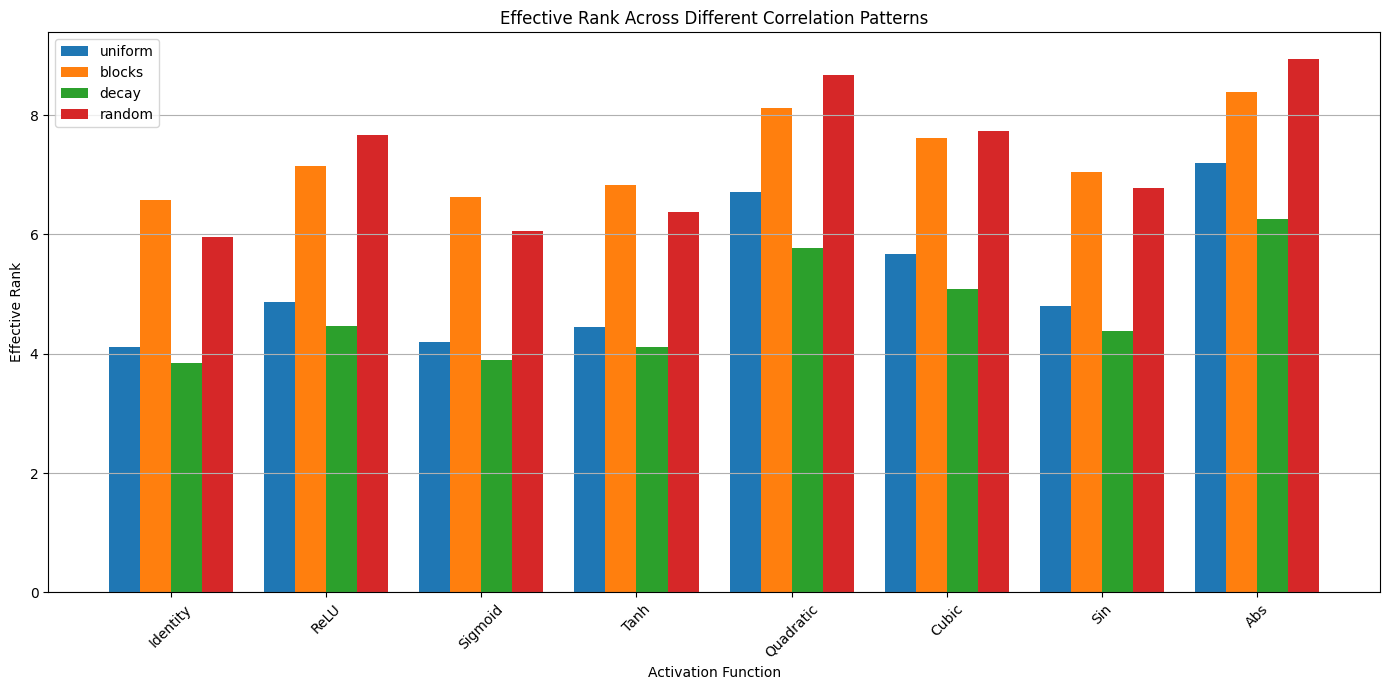

Running Gaussianity impact test...
Plotting Gaussianity test results...


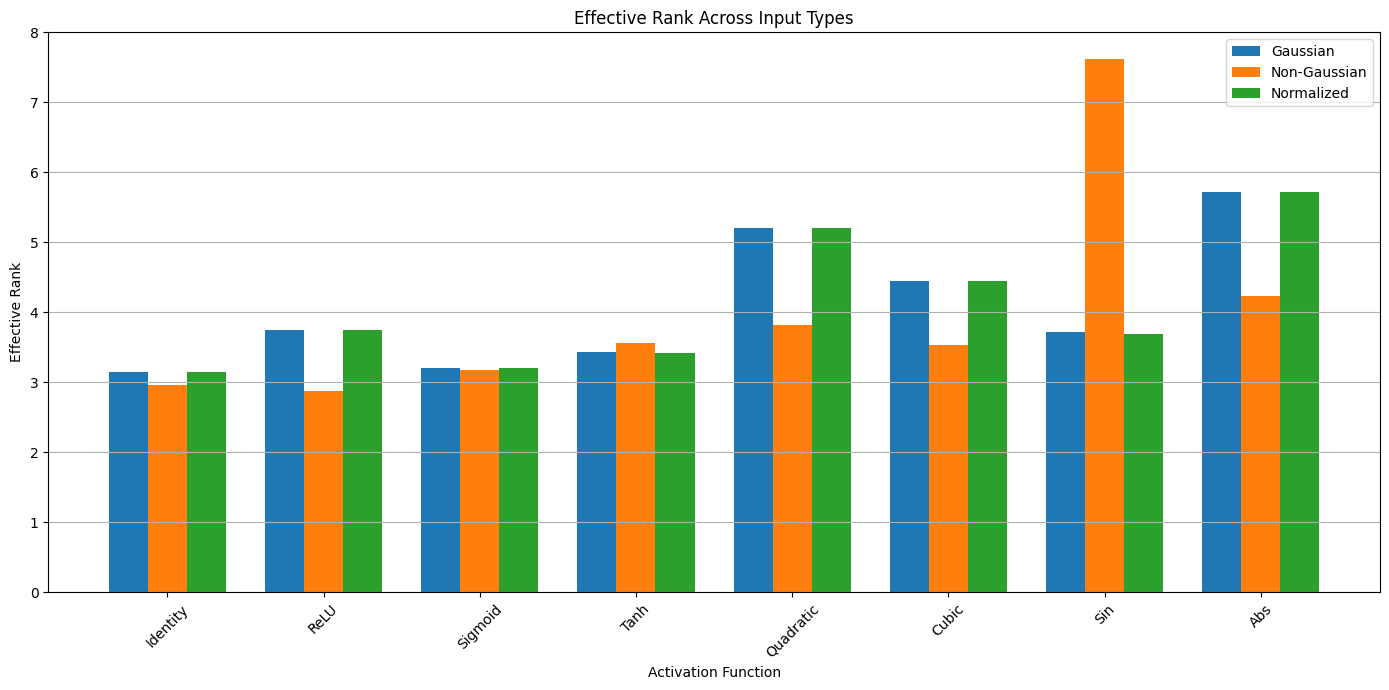

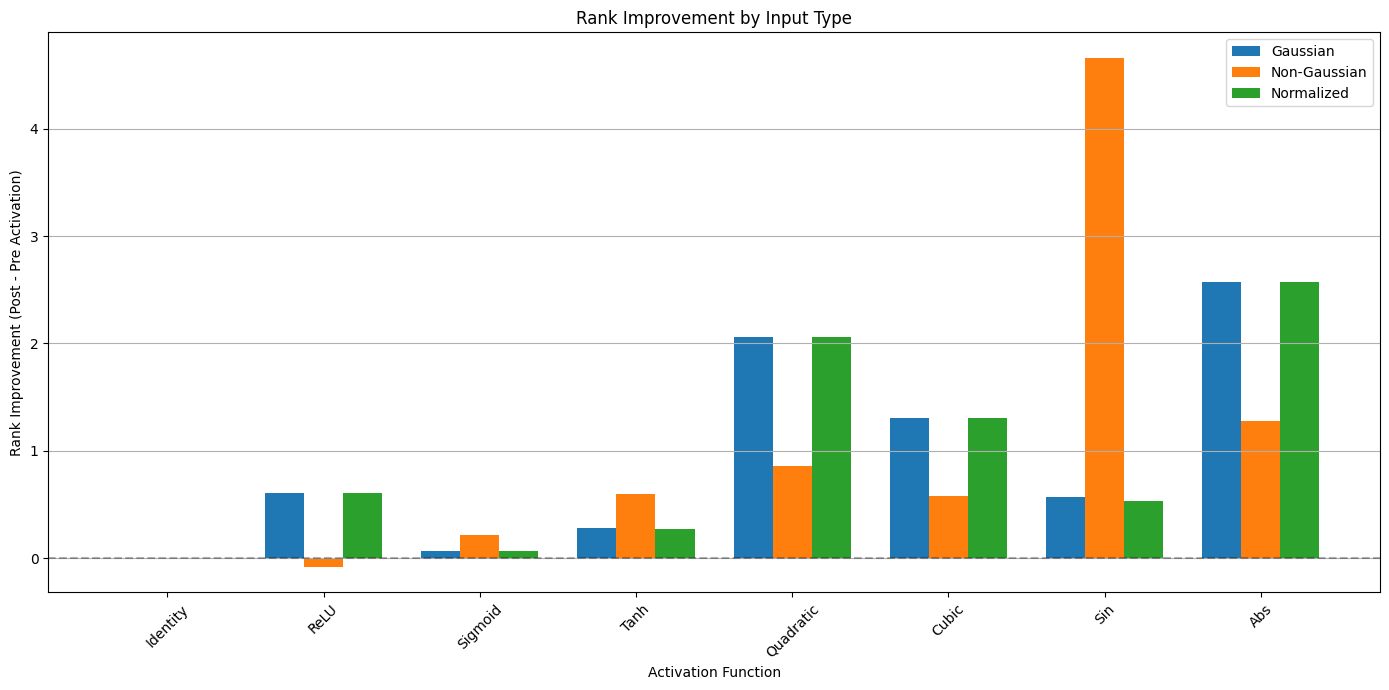

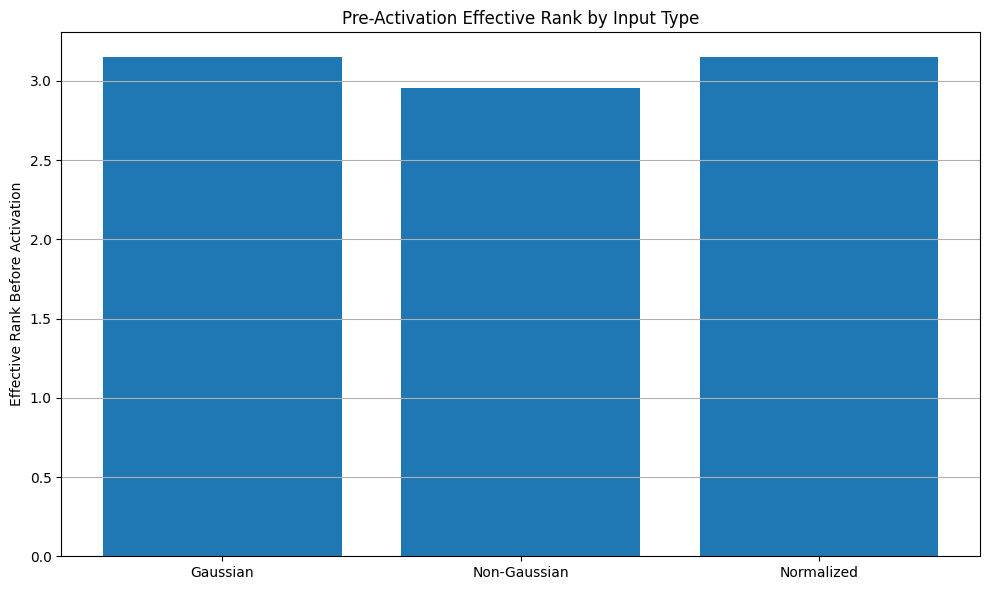

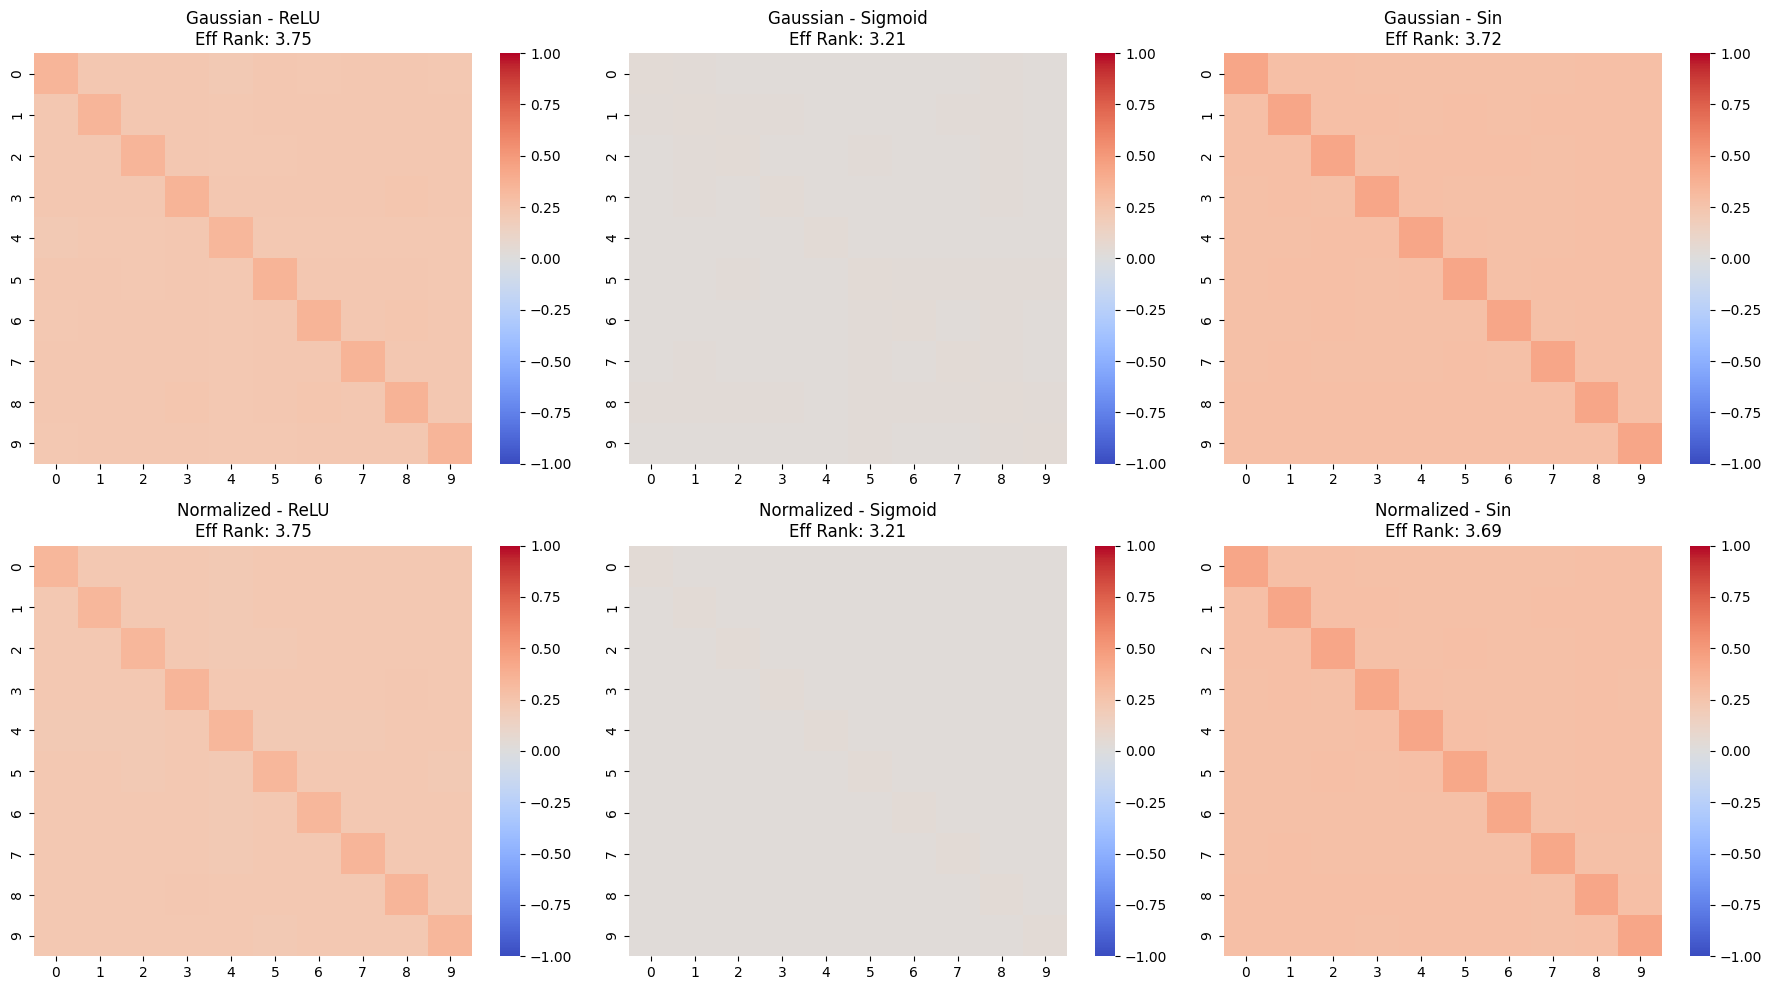


Numerical results for uniform correlation pattern:

Correlation strength: 0.0
  Identity  : Matrix Rank = 10, Effective Rank = 9.99
  ReLU      : Matrix Rank = 10, Effective Rank = 9.99
  Sigmoid   : Matrix Rank = 10, Effective Rank = 9.99
  Tanh      : Matrix Rank = 10, Effective Rank = 10.00
  Quadratic : Matrix Rank = 10, Effective Rank = 9.99
  Cubic     : Matrix Rank = 10, Effective Rank = 9.97
  Sin       : Matrix Rank = 10, Effective Rank = 10.00
  Abs       : Matrix Rank = 10, Effective Rank = 9.99

Correlation strength: 0.6
  Identity  : Matrix Rank = 10, Effective Rank = 4.11
  ReLU      : Matrix Rank = 10, Effective Rank = 4.87
  Sigmoid   : Matrix Rank = 10, Effective Rank = 4.20
  Tanh      : Matrix Rank = 10, Effective Rank = 4.45
  Quadratic : Matrix Rank = 10, Effective Rank = 6.71
  Cubic     : Matrix Rank = 10, Effective Rank = 5.67
  Sin       : Matrix Rank = 10, Effective Rank = 4.81
  Abs       : Matrix Rank = 10, Effective Rank = 7.19

Correlation strength: 0.99


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import pairwise_distances
import seaborn as sns
from sklearn.preprocessing import StandardScaler

def generate_correlated_gaussians(n_samples, n_features, corr_strength, seed=42, 
                                 zero_mean=True, unit_variance=True):
    """
    Generate correlated Gaussian samples
    
    Parameters:
    - n_samples: number of samples to generate
    - n_features: dimension of each sample
    - corr_strength: correlation strength between features (between 0 and 1)
    - seed: random seed for reproducibility
    - zero_mean: if False, add random non-zero means to features
    - unit_variance: if False, use random variances instead of unit variance
    
    Returns:
    - samples: array of shape (n_samples, n_features)
    - cov_matrix: the true covariance matrix used
    """
    np.random.seed(seed)
    
    # Create a correlation matrix with off-diagonal elements = corr_strength
    corr_matrix = np.ones((n_features, n_features)) * corr_strength
    np.fill_diagonal(corr_matrix, 1.0)
    
    # Generate base multivariate normal samples with correlation
    base_samples = np.random.multivariate_normal(
        mean=np.zeros(n_features),
        cov=corr_matrix,
        size=n_samples
    )
    
    # If we want non-unit variance, scale the features
    if not unit_variance:
        # Generate random variances between 0.5 and 5
        variances = np.random.uniform(0.5, 5, size=n_features)
        scaling_factors = np.sqrt(variances)
        base_samples = base_samples * scaling_factors
    
    # If we want non-zero mean, shift the features
    if not zero_mean:
        # Generate random means between -5 and 5
        means = np.random.uniform(-5, 5, size=n_features)
        samples = base_samples + means
    else:
        samples = base_samples
    
    return samples, corr_matrix

def create_custom_correlation_matrix(n_features, pattern="blocks"):
    """
    Create correlation matrices with specific patterns
    
    Parameters:
    - n_features: dimension of the matrix
    - pattern: type of pattern to create
    
    Returns:
    - corr_matrix: correlation matrix
    """
    if pattern == "blocks":
        # Create a block-diagonal correlation matrix
        corr_matrix = np.eye(n_features)
        block_size = n_features // 3  # Divide features into 3 blocks
        
        # Set correlation within blocks
        for i in range(0, n_features, block_size):
            end_idx = min(i + block_size, n_features)
            block = np.ones((end_idx - i, end_idx - i)) * 0.7
            np.fill_diagonal(block, 1.0)
            corr_matrix[i:end_idx, i:end_idx] = block
            
    elif pattern == "decay":
        # Create a correlation matrix where correlation decays with distance
        distances = pairwise_distances(np.arange(n_features)[:, np.newaxis])
        corr_matrix = np.exp(-0.2 * distances)  # Exponential decay
        
    elif pattern == "random":
        # Create a random correlation matrix
        np.random.seed(42)
        A = np.random.randn(n_features, n_features)
        # Make it symmetric and positive definite
        corr_matrix = A @ A.T
        # Convert to correlation matrix
        d = np.sqrt(np.diag(corr_matrix))
        corr_matrix = corr_matrix / np.outer(d, d)
        
    return corr_matrix

def activation_functions():
    """Return a dictionary of activation functions"""
    return {
        "Identity": lambda x: x,
        "ReLU": lambda x: np.maximum(0, x),
        "Sigmoid": lambda x: 1 / (1 + np.exp(-x)),
        "Tanh": lambda x: np.tanh(x),
        "Quadratic": lambda x: x**2,  # Polynomial for comparison
        "Cubic": lambda x: x**3,      # Polynomial for comparison
        "Sin": lambda x: np.sin(x),   # Non-polynomial
        "Abs": lambda x: np.abs(x)    # Non-polynomial
    }

def compute_effective_rank(matrix):
    """
    Compute the effective rank of a matrix using singular values
    
    Effective rank is defined as exp(entropy of normalized singular values)
    """
    # Compute SVD
    s = np.linalg.svd(matrix, compute_uv=False)
    
    # Normalize singular values
    s_norm = s / np.sum(s)
    
    # Remove zeros to avoid log(0)
    s_norm = s_norm[s_norm > 1e-10]
    
    # Compute entropy
    entropy = -np.sum(s_norm * np.log(s_norm))
    
    # Effective rank
    return np.exp(entropy)

def test_rank_preservation():
    """Test the rank preservation proposition with different settings"""
    n_samples = 10000  # Large number for stable covariance estimation
    n_features = 10
    
    # Different correlation strengths
    corr_strengths = [0.0, 0.3, 0.6, 0.9, 0.99]
    
    # Different correlation patterns
    patterns = ["uniform", "blocks", "decay", "random"]
    
    # Get activation functions
    activations = activation_functions()
    
    # Results container: pattern -> corr_strength -> activation -> rank
    results = {}
    
    # Test with uniform correlation matrices at different strengths
    pattern = "uniform"
    results[pattern] = {}
    
    for corr_strength in corr_strengths:
        # Generate samples and get true covariance
        samples, true_cov = generate_correlated_gaussians(
            n_samples, n_features, corr_strength
        )
        
        # Estimate sample covariance for validation
        sample_cov = np.cov(samples, rowvar=False)
        
        # Compute rank metrics for each activation function
        act_results = {}
        for name, func in activations.items():
            # Apply activation
            activated = func(samples)
            
            # Compute covariance of activated features
            activated_cov = np.cov(activated, rowvar=False)
            
            # Compute rank metrics
            matrix_rank = np.linalg.matrix_rank(activated_cov)
            eff_rank = compute_effective_rank(activated_cov)
            condition_number = np.linalg.cond(activated_cov)
            
            act_results[name] = {
                "matrix_rank": matrix_rank,
                "effective_rank": eff_rank,
                "condition_number": condition_number,
                "covariance": activated_cov
            }
        
        results[pattern][corr_strength] = act_results
    
    # Test with different correlation patterns
    for pattern in ["blocks", "decay", "random"]:
        results[pattern] = {}
        
        # Create correlation matrix with the specified pattern
        true_cov = create_custom_correlation_matrix(n_features, pattern)
        
        # Generate samples from this correlation matrix
        np.random.seed(42)
        samples = np.random.multivariate_normal(
            mean=np.zeros(n_features),
            cov=true_cov,
            size=n_samples
        )
        
        # Estimate sample covariance for validation
        sample_cov = np.cov(samples, rowvar=False)
        
        # Compute rank metrics for each activation function
        act_results = {}
        for name, func in activations.items():
            # Apply activation
            activated = func(samples)
            
            # Compute covariance of activated features
            activated_cov = np.cov(activated, rowvar=False)
            
            # Compute rank metrics
            matrix_rank = np.linalg.matrix_rank(activated_cov)
            eff_rank = compute_effective_rank(activated_cov)
            condition_number = np.linalg.cond(activated_cov)
            
            act_results[name] = {
                "matrix_rank": matrix_rank,
                "effective_rank": eff_rank,
                "condition_number": condition_number,
                "covariance": activated_cov
            }
        
        results[pattern]["pattern"] = act_results
    
    return results

def test_gaussianity_impact():
    """Test how non-Gaussian inputs impact rank preservation and if normalization helps"""
    n_samples = 10000
    n_features = 10
    corr_strength = 0.7  # Medium-strong correlation
    
    # Get activation functions
    activations = activation_functions()
    
    # Results dictionary
    results = {
        "gaussian": {},         # Pure Gaussian (zero-mean, unit-variance)
        "non_gaussian": {},     # Non-Gaussian (non-zero mean, non-unit variance)
        "normalized": {}        # Non-Gaussian -> Normalized
    }
    
    # Generate pure Gaussian samples
    gaussian_samples, _ = generate_correlated_gaussians(
        n_samples, n_features, corr_strength,
        zero_mean=True, unit_variance=True
    )
    
    # Generate non-Gaussian samples (non-zero mean, non-unit variance)
    non_gaussian_samples, _ = generate_correlated_gaussians(
        n_samples, n_features, corr_strength,
        zero_mean=False, unit_variance=False
    )
    
    # Normalize the non-Gaussian samples
    scaler = StandardScaler()
    normalized_samples = scaler.fit_transform(non_gaussian_samples)
    
    # Calculate effective rank before activation for each sample type
    pre_ranks = {
        "gaussian": compute_effective_rank(np.cov(gaussian_samples, rowvar=False)),
        "non_gaussian": compute_effective_rank(np.cov(non_gaussian_samples, rowvar=False)),
        "normalized": compute_effective_rank(np.cov(normalized_samples, rowvar=False))
    }
    
    # For each sample type, apply activations and measure rank
    for sample_type, samples in [
        ("gaussian", gaussian_samples),
        ("non_gaussian", non_gaussian_samples),
        ("normalized", normalized_samples)
    ]:
        # For each activation function
        for name, func in activations.items():
            # Apply activation
            activated = func(samples)
            
            # Compute covariance and rank metrics
            activated_cov = np.cov(activated, rowvar=False)
            matrix_rank = np.linalg.matrix_rank(activated_cov)
            eff_rank = compute_effective_rank(activated_cov)
            condition_number = np.linalg.cond(activated_cov)
            
            # Calculate rank improvement
            rank_improvement = eff_rank - pre_ranks[sample_type]
            
            results[sample_type][name] = {
                "matrix_rank": matrix_rank,
                "effective_rank": eff_rank,
                "condition_number": condition_number,
                "pre_activation_rank": pre_ranks[sample_type],
                "rank_improvement": rank_improvement,
                "covariance": activated_cov
            }
    
    return results

def plot_results(results):
    """Plot the results of the rank preservation test"""
    
    # Plot correlation strengths vs effective rank
    plt.figure(figsize=(14, 7))
    pattern = "uniform"
    
    # Extract activations and correlation strengths
    activations = list(results[pattern][0.0].keys())
    corr_strengths = list(results[pattern].keys())
    
    for act_name in activations:
        eff_ranks = [results[pattern][corr][act_name]["effective_rank"] 
                     for corr in corr_strengths]
        plt.plot(corr_strengths, eff_ranks, 'o-', label=act_name)
    
    plt.xlabel("Correlation Strength")
    plt.ylabel("Effective Rank")
    plt.title("Effect of Correlation Strength on Effective Rank After Activation")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot heatmaps of covariance matrices after different activations
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    pattern = "uniform"
    corr_strength = 0.6  # Choose a medium correlation
    
    for i, (act_name, ax) in enumerate(zip(activations, axes)):
        cov = results[pattern][corr_strength][act_name]["covariance"]
        sns.heatmap(cov, annot=False, cmap='coolwarm', vmin=-1, vmax=1, ax=ax)
        ax.set_title(f"{act_name} Activation\nEff Rank: {results[pattern][corr_strength][act_name]['effective_rank']:.2f}")
    
    plt.tight_layout()
    plt.show()

    # Compare effective ranks across different correlation patterns
    plt.figure(figsize=(14, 7))
    patterns = ["uniform", "blocks", "decay", "random"]
    x = np.arange(len(activations))
    width = 0.2
    
    for i, pattern in enumerate(patterns):
        if pattern == "uniform":
            # For uniform, use medium correlation
            eff_ranks = [results[pattern][0.6][act]["effective_rank"] 
                         for act in activations]
        else:
            eff_ranks = [results[pattern]["pattern"][act]["effective_rank"] 
                         for act in activations]
        
        plt.bar(x + i*width, eff_ranks, width, label=pattern)
    
    plt.xlabel("Activation Function")
    plt.ylabel("Effective Rank")
    plt.title("Effective Rank Across Different Correlation Patterns")
    plt.xticks(x + width*1.5, activations, rotation=45)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

def plot_gaussianity_results(results):
    """Plot the results of the Gaussianity impact test"""
    
    # Extract activation names
    activations = list(results["gaussian"].keys())
    
    # Plot the effective rank for each type of input
    plt.figure(figsize=(14, 7))
    x = np.arange(len(activations))
    width = 0.25
    
    # Get effective ranks for each type and activation
    gaussian_ranks = [results["gaussian"][act]["effective_rank"] for act in activations]
    non_gaussian_ranks = [results["non_gaussian"][act]["effective_rank"] for act in activations]
    normalized_ranks = [results["normalized"][act]["effective_rank"] for act in activations]
    
    # Create the grouped bar chart
    plt.bar(x - width, gaussian_ranks, width, label="Gaussian")
    plt.bar(x, non_gaussian_ranks, width, label="Non-Gaussian")
    plt.bar(x + width, normalized_ranks, width, label="Normalized")
    
    plt.xlabel("Activation Function")
    plt.ylabel("Effective Rank")
    plt.title("Effective Rank Across Input Types")
    plt.xticks(x, activations, rotation=45)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Plot the rank improvement for each type
    plt.figure(figsize=(14, 7))
    
    # Calculate rank improvements
    gaussian_improvement = [results["gaussian"][act]["rank_improvement"] for act in activations]
    non_gaussian_improvement = [results["non_gaussian"][act]["rank_improvement"] for act in activations]
    normalized_improvement = [results["normalized"][act]["rank_improvement"] for act in activations]
    
    # Create the grouped bar chart
    plt.bar(x - width, gaussian_improvement, width, label="Gaussian")
    plt.bar(x, non_gaussian_improvement, width, label="Non-Gaussian")
    plt.bar(x + width, normalized_improvement, width, label="Normalized")
    
    plt.xlabel("Activation Function")
    plt.ylabel("Rank Improvement (Post - Pre Activation)")
    plt.title("Rank Improvement by Input Type")
    plt.xticks(x, activations, rotation=45)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Plot comparison of pre-activation effective ranks
    plt.figure(figsize=(10, 6))
    pre_ranks = [
        results["gaussian"]["Identity"]["pre_activation_rank"],
        results["non_gaussian"]["Identity"]["pre_activation_rank"],
        results["normalized"]["Identity"]["pre_activation_rank"]
    ]
    plt.bar(['Gaussian', 'Non-Gaussian', 'Normalized'], pre_ranks)
    plt.ylabel('Effective Rank Before Activation')
    plt.title('Pre-Activation Effective Rank by Input Type')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
    
    # Plot heatmaps to compare covariance matrices
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Pick a few interesting activations
    selected_activations = ["ReLU", "Sigmoid", "Sin"]
    
    for i, act_name in enumerate(selected_activations):
        # Gaussian cov matrix
        cov_gaussian = results["gaussian"][act_name]["covariance"]
        sns.heatmap(cov_gaussian, annot=False, cmap='coolwarm', 
                   vmin=-1, vmax=1, ax=axes[0, i])
        axes[0, i].set_title(f"Gaussian - {act_name}\nEff Rank: {results['gaussian'][act_name]['effective_rank']:.2f}")
        
        # Normalized cov matrix
        cov_normalized = results["normalized"][act_name]["covariance"]
        sns.heatmap(cov_normalized, annot=False, cmap='coolwarm', 
                   vmin=-1, vmax=1, ax=axes[1, i])
        axes[1, i].set_title(f"Normalized - {act_name}\nEff Rank: {results['normalized'][act_name]['effective_rank']:.2f}")
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Run the standard rank preservation test
    print("Running standard rank preservation test...")
    results_standard = test_rank_preservation()
    
    # Plot the standard results
    print("Plotting standard test results...")
    plot_results(results_standard)
    
    # Run the Gaussianity impact test
    print("Running Gaussianity impact test...")
    results_gaussianity = test_gaussianity_impact()
    
    # Plot the Gaussianity results
    print("Plotting Gaussianity test results...")
    plot_gaussianity_results(results_gaussianity)
    
    # Print numerical results for uniform correlation pattern
    print("\nNumerical results for uniform correlation pattern:")
    for corr in [0.0, 0.6, 0.99]:
        print(f"\nCorrelation strength: {corr}")
        for act_name in activation_functions().keys():
            eff_rank = results_standard["uniform"][corr][act_name]["effective_rank"]
            matrix_rank = results_standard["uniform"][corr][act_name]["matrix_rank"]
            print(f"  {act_name.ljust(10)}: Matrix Rank = {matrix_rank}, Effective Rank = {eff_rank:.2f}")
    
    # Print numerical results for Gaussianity test
    print("\nNumerical results for Gaussianity impact test:")
    print("\nPre-activation effective ranks:")
    for input_type in ["gaussian", "non_gaussian", "normalized"]:
        pre_rank = results_gaussianity[input_type]["Identity"]["pre_activation_rank"]
        print(f"  {input_type.ljust(12)}: {pre_rank:.2f}")
    
    print("\nPost-activation effective ranks and improvements:")
    for act_name in activation_functions().keys():
        print(f"\n{act_name} activation:")
        for input_type in ["gaussian", "non_gaussian", "normalized"]:
            eff_rank = results_gaussianity[input_type][act_name]["effective_rank"]
            improvement = results_gaussianity[input_type][act_name]["rank_improvement"]
            print(f"  {input_type.ljust(12)}: Eff Rank = {eff_rank:.2f}, Improvement = {improvement:.2f}")

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy import stats
import pandas as pd
from tqdm import tqdm
import os
from collections import defaultdict

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class MLP(nn.Module):
    """
    Multi-layer perceptron with configurable normalization layers
    """
    def __init__(self, 
                 input_dim=100, 
                 hidden_dims=[256, 128, 64], 
                 output_dim=10,
                 activation=nn.ReLU,
                 norm_type=None,  # 'bn', 'ln', None
                 affine=True,     # Whether to use learnable affine parameters in normalization
                 track_pre_activations=False):
        super(MLP, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.norm_type = norm_type
        self.affine = affine
        self.track_pre_activations = track_pre_activations
        
        # Create network
        layers = []
        prev_dim = input_dim
        
        # Hidden layers
        for i, dim in enumerate(hidden_dims):
            # Linear layer
            layers.append(nn.Linear(prev_dim, dim))
            
            # Normalization layer
            if norm_type == 'bn':
                layers.append(nn.BatchNorm1d(dim, affine=affine))
            elif norm_type == 'ln':
                layers.append(nn.LayerNorm(dim, elementwise_affine=affine))
            
            # Activation
            layers.append(activation())
            
            prev_dim = dim
        
        # Output layer
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.layers = nn.ModuleList(layers)
        self.pre_activations = []  # For storing pre-activation values
        
    def forward(self, x):
        self.pre_activations = []  # Reset for each forward pass
        
        # Store each layer's output for rank analysis
        activations = []
        h = x
        
        layer_index = 0
        while layer_index < len(self.layers):
            # Apply linear layer
            linear_layer = self.layers[layer_index]
            h = linear_layer(h)
            
            # Store pre-activation (after linear, before norm and activation)
            if self.track_pre_activations:
                self.pre_activations.append(h.detach().clone())
            
            # Move to next layer (could be norm or activation)
            layer_index += 1
            
            # Apply normalization if present
            if layer_index < len(self.layers) and (
                isinstance(self.layers[layer_index], nn.BatchNorm1d) or 
                isinstance(self.layers[layer_index], nn.LayerNorm)):
                norm_layer = self.layers[layer_index]
                h = norm_layer(h)
                layer_index += 1
            
            # Apply activation if present
            if layer_index < len(self.layers) and (
                isinstance(self.layers[layer_index], nn.ReLU) or
                isinstance(self.layers[layer_index], nn.Tanh) or
                isinstance(self.layers[layer_index], nn.Sigmoid)):
                activation_layer = self.layers[layer_index]
                h = activation_layer(h)
                # Store post-activation
                activations.append(h.detach().clone())
                layer_index += 1
        
        return h, activations

def generate_dataset(n_samples=10000, input_dim=100, n_classes=10, corr_strength=0.7):
    """
    Generate a synthetic dataset with correlated features
    """
    # Create a correlation matrix
    corr_matrix = np.ones((input_dim, input_dim)) * corr_strength
    np.fill_diagonal(corr_matrix, 1.0)
    
    # Generate correlated features
    X = np.random.multivariate_normal(
        mean=np.zeros(input_dim),
        cov=corr_matrix,
        size=n_samples
    )
    
    # Standardize features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Generate target labels (random for simplicity)
    y = np.random.randint(0, n_classes, size=n_samples)
    
    return X, y

def compute_effective_rank(matrix):
    """
    Compute the effective rank of a matrix using singular values
    """
    # Convert to numpy if it's a torch tensor
    if isinstance(matrix, torch.Tensor):
        matrix = matrix.cpu().numpy()
    
    # Compute SVD
    s = np.linalg.svd(matrix, compute_uv=False)
    
    # Normalize singular values
    s_norm = s / np.sum(s)
    
    # Remove zeros to avoid log(0)
    s_norm = s_norm[s_norm > 1e-10]
    
    # Compute entropy
    entropy = -np.sum(s_norm * np.log(s_norm))
    
    # Effective rank
    return np.exp(entropy)

def test_gaussianity(data, alpha=0.05):
    """
    Test if each feature follows a Gaussian distribution
    Returns the percentage of features that pass the test
    """
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    
    n_features = data.shape[1]
    gaussian_count = 0
    
    for i in range(n_features):
        feature = data[:, i]
        # Use Shapiro-Wilk test for normality
        # Taking a random sample of 5000 points max (Shapiro-Wilk works best with smaller samples)
        if len(feature) > 5000:
            feature = np.random.choice(feature, size=5000, replace=False)
        _, p_value = stats.shapiro(feature)
        
        if p_value > alpha:
            gaussian_count += 1
    
    return gaussian_count / n_features

def plot_feature_distributions(data, layer_name, norm_type, n_features=5):
    """
    Plot histograms of a few random features to visually inspect their distributions
    """
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    
    # Select random features
    feature_indices = np.random.choice(data.shape[1], size=min(n_features, data.shape[1]), replace=False)
    
    fig, axes = plt.subplots(1, len(feature_indices), figsize=(15, 3))
    if len(feature_indices) == 1:
        axes = [axes]
    
    for i, idx in enumerate(feature_indices):
        feature = data[:, idx]
        ax = axes[i]
        
        # Plot histogram
        ax.hist(feature, bins=30, alpha=0.7, density=True)
        
        # Plot normal distribution for comparison
        mu, std = np.mean(feature), np.std(feature)
        x = np.linspace(mu - 3*std, mu + 3*std, 100)
        ax.plot(x, stats.norm.pdf(x, mu, std), 'r-', alpha=0.7)
        
        # Shapiro-Wilk test
        if len(feature) > 5000:
            sampled_feature = np.random.choice(feature, size=5000, replace=False)
            _, p_value = stats.shapiro(sampled_feature)
        else:
            _, p_value = stats.shapiro(feature)
        
        ax.set_title(f"Feature {idx}\np-value: {p_value:.3f}")
        
    plt.suptitle(f"{layer_name} - {norm_type}")
    plt.tight_layout()
    return fig

def train_model(model, train_loader, val_loader, epochs=5):
    """
    Train the model and return training metrics
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs, _ = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return {'train_losses': train_losses, 'val_losses': val_losses}

def analyze_layer_activations(model, data_loader, norm_type, affine):
    """
    Analyze pre and post activations of each layer in the model
    """
    model.eval()
    model.track_pre_activations = True
    
    # Collect pre and post activations
    all_pre_activations = []
    all_post_activations = []
    
    # First, do a single forward pass to determine the structure
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            _, activations = model(inputs)
            break
    
    # Initialize lists with the correct number of layers
    all_pre_activations = [[] for _ in range(len(model.pre_activations))]
    all_post_activations = [[] for _ in range(len(activations))]
    
    # Now collect all activations
    with torch.no_grad():
        for inputs, _ in tqdm(data_loader, desc="Collecting activations"):
            inputs = inputs.to(device)
            _, activations = model(inputs)
            
            # Store pre activations
            for i, pre_act in enumerate(model.pre_activations):
                all_pre_activations[i].append(pre_act)
            
            # Store post activations
            for i, post_act in enumerate(activations):
                all_post_activations[i].append(post_act)
    
    # Concatenate batches
    all_pre_activations = [torch.cat(pre_acts, dim=0) for pre_acts in all_pre_activations]
    all_post_activations = [torch.cat(post_acts, dim=0) for post_acts in all_post_activations]
    
    # Analyze each layer
    results = []
    
    # Ensure we only analyze layers where we have both pre and post activations
    n_layers = min(len(all_pre_activations), len(all_post_activations))
    
    for layer_idx in range(n_layers):
        pre_act = all_pre_activations[layer_idx]
        post_act = all_post_activations[layer_idx]
        
        # Compute covariance matrices
        pre_cov = np.cov(pre_act.cpu().numpy(), rowvar=False)
        post_cov = np.cov(post_act.cpu().numpy(), rowvar=False)
        
        # Compute effective ranks
        pre_rank = compute_effective_rank(pre_cov)
        post_rank = compute_effective_rank(post_cov)
        rank_improvement = post_rank - pre_rank
        
        # Test Gaussianity
        pre_gaussianity = test_gaussianity(pre_act)
        post_gaussianity = test_gaussianity(post_act)
        
        # Layer info
        layer_info = {
            'layer_idx': layer_idx,
            'pre_rank': pre_rank,
            'post_rank': post_rank,
            'rank_improvement': rank_improvement,
            'pre_gaussianity': pre_gaussianity,
            'post_gaussianity': post_gaussianity,
            'norm_type': norm_type,
            'affine': affine
        }
        
        results.append(layer_info)
        
        # Create and save visualization plots
        plot_dir = f"plots/norm_{norm_type}_affine_{affine}"
        os.makedirs(plot_dir, exist_ok=True)
        
        # Plot feature distributions
        pre_fig = plot_feature_distributions(
            pre_act, f"Layer {layer_idx} Pre-Activation", 
            f"{norm_type}, affine={affine}"
        )
        pre_fig.savefig(f"{plot_dir}/layer_{layer_idx}_pre_dist.png")
        plt.close(pre_fig)
        
        post_fig = plot_feature_distributions(
            post_act, f"Layer {layer_idx} Post-Activation", 
            f"{norm_type}, affine={affine}"
        )
        post_fig.savefig(f"{plot_dir}/layer_{layer_idx}_post_dist.png")
        plt.close(post_fig)
        
        # Plot covariance matrices
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        
        sns.heatmap(pre_cov, ax=axes[0], cmap='coolwarm')
        axes[0].set_title(f"Pre-Activation Covariance\nEff Rank: {pre_rank:.2f}")
        
        sns.heatmap(post_cov, ax=axes[1], cmap='coolwarm')
        axes[1].set_title(f"Post-Activation Covariance\nEff Rank: {post_rank:.2f}")
        
        plt.suptitle(f"Layer {layer_idx}, {norm_type}, affine={affine}")
        plt.tight_layout()
        plt.savefig(f"{plot_dir}/layer_{layer_idx}_covariance.png")
        plt.close()
    
    return results

def run_experiment(input_dim=100, hidden_dims=[128, 64, 32], output_dim=10, 
                  activation=nn.ReLU, batch_size=128, epochs=5):
    """
    Run the experiment for different normalization configurations
    """
    # Generate data
    print("Generating dataset...")
    X_train, y_train = generate_dataset(n_samples=50000, input_dim=input_dim, n_classes=output_dim)
    X_val, y_val = generate_dataset(n_samples=10000, input_dim=input_dim, n_classes=output_dim)
    
    # Create data loaders
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                                torch.tensor(y_train, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                               torch.tensor(y_val, dtype=torch.long))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Normalization configurations to test
    configs = [
        {'norm_type': None, 'affine': False, 'name': 'No Normalization'},
        {'norm_type': 'bn', 'affine': False, 'name': 'BN without affine'},
        {'norm_type': 'bn', 'affine': True, 'name': 'BN with affine'},
        {'norm_type': 'ln', 'affine': False, 'name': 'LN without affine'},
        {'norm_type': 'ln', 'affine': True, 'name': 'LN with affine'}
    ]
    
    all_results = []
    
    for config in configs:
        print(f"\n{'='*50}")
        print(f"Testing {config['name']}")
        print(f"{'='*50}")
        
        # Create model
        model = MLP(
            input_dim=input_dim,
            hidden_dims=hidden_dims,
            output_dim=output_dim,
            activation=activation,
            norm_type=config['norm_type'],
            affine=config['affine']
        ).to(device)
        
        # Train model
        train_metrics = train_model(model, train_loader, val_loader, epochs=epochs)
        
        # Analyze activations
        layer_results = analyze_layer_activations(
            model, val_loader, config['norm_type'], config['affine']
        )
        
        # Add to all results
        for res in layer_results:
            res['config_name'] = config['name']
            all_results.append(res)
    
    return all_results

def plot_combined_results(results):
    """
    Create summary plots comparing different normalization strategies
    """
    # Convert results to DataFrame for easier analysis
    df = pd.DataFrame(results)
    
    # Create plots directory
    os.makedirs("plots/summary", exist_ok=True)
    
    # 1. Rank improvement by layer and normalization type
    plt.figure(figsize=(12, 8))
    sns.barplot(x='layer_idx', y='rank_improvement', hue='config_name', data=df)
    plt.title('Rank Improvement (Post - Pre) by Layer and Normalization')
    plt.xlabel('Layer Index')
    plt.ylabel('Rank Improvement')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig('plots/summary/rank_improvement.png')
    plt.close()
    
    # 2. Pre-activation Gaussianity by layer and normalization type
    plt.figure(figsize=(12, 8))
    sns.barplot(x='layer_idx', y='pre_gaussianity', hue='config_name', data=df)
    plt.title('Pre-Activation Gaussianity by Layer and Normalization')
    plt.xlabel('Layer Index')
    plt.ylabel('Fraction of Features with Gaussian Distribution')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig('plots/summary/pre_gaussianity.png')
    plt.close()
    
    # 3. Correlation: Gaussianity vs Rank Improvement
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x='pre_gaussianity', y='rank_improvement', 
                   hue='config_name', style='layer_idx', s=100, data=df)
    plt.title('Correlation: Pre-Activation Gaussianity vs Rank Improvement')
    plt.xlabel('Pre-Activation Gaussianity')
    plt.ylabel('Rank Improvement')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('plots/summary/gaussianity_vs_improvement.png')
    plt.close()
    
    # 4. Pre and Post effective rank by layer and normalization
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    sns.barplot(x='layer_idx', y='pre_rank', hue='config_name', ax=axes[0], data=df)
    axes[0].set_title('Pre-Activation Effective Rank')
    axes[0].set_xlabel('Layer Index')
    axes[0].set_ylabel('Effective Rank')
    axes[0].grid(True, axis='y')
    
    sns.barplot(x='layer_idx', y='post_rank', hue='config_name', ax=axes[1], data=df)
    axes[1].set_title('Post-Activation Effective Rank')
    axes[1].set_xlabel('Layer Index')
    axes[1].set_ylabel('Effective Rank')
    axes[1].grid(True, axis='y')
    
    plt.suptitle('Effective Rank by Layer and Normalization', fontsize=16)
    plt.tight_layout()
    plt.savefig('plots/summary/effective_ranks.png')
    plt.close()
    
    # 5. Average results table
    avg_results = df.groupby('config_name').agg({
        'pre_gaussianity': 'mean',
        'post_gaussianity': 'mean',
        'pre_rank': 'mean',
        'post_rank': 'mean',
        'rank_improvement': 'mean'
    }).reset_index()
    
    print("\nAverage results across all layers:")
    print(avg_results)
    
    # Save as CSV
    avg_results.to_csv('plots/summary/average_results.csv', index=False)
    
    return avg_results

if __name__ == "__main__":
    # Create output directories
    os.makedirs("plots", exist_ok=True)
    
    # Run experiments
    print("Starting normalization experiments...")
    all_results = run_experiment(
        input_dim=100,
        hidden_dims=[128,]*5,
        output_dim=10,
        activation=nn.Tanh,
        batch_size=128,
        epochs=3  # Fewer epochs for faster experiment
    )
    
    # Plot summary results
    avg_results = plot_combined_results(all_results)
    
    print("Experiment completed! Results and visualizations are saved in the 'plots' directory.")

Using device: cuda
Starting normalization experiments...
Generating dataset...

Testing No Normalization


Epoch 1/3, Train Loss: 2.3047, Val Loss: 2.3043
Epoch 2/3, Train Loss: 2.3038, Val Loss: 2.3034
Epoch 3/3, Train Loss: 2.3032, Val Loss: 2.3033



Testing BN without affine
Epoch 1/3, Train Loss: 2.3134, Val Loss: 2.3090
Epoch 2/3, Train Loss: 2.3078, Val Loss: 2.3125
Epoch 3/3, Train Loss: 2.3080, Val Loss: 2.3073



Testing BN with affine
Epoch 1/3, Train Loss: 2.3136, Val Loss: 2.3180
Epoch 2/3, Train Loss: 2.3072, Val Loss: 2.3200
Epoch 3/3, Train Loss: 2.3066, Val Loss: 2.3127



Testing LN without affine
Epoch 1/3, Train Loss: 2.3130, Val Loss: 2.3090
Epoch 2/3, Train Loss: 2.3061, Val Loss: 2.3106
Epoch 3/3, Train Loss: 2.3065, Val Loss: 2.3082



Testing LN with affine
Epoch 1/3, Train Loss: 2.3126, Val Loss: 2.3165
Epoch 2/3, Train Loss: 2.3068, Val Loss: 2.3098
Epoch 3/3, Train Loss: 2.3061, Val Loss: 2.3050



Average results across all layers:
         config_name  pre_gaussianity  post_gaussianity   pre_rank  post_rank  \
0     BN with affine         0.214062            0.0000   1.851334   3.347574   
1  BN without affine         0.215625            0.0000   1.797465   3.266783   
2     LN with affine         0.195312            0.0000   1.539400   3.000671   
3  LN without affine         0.196875            0.0000   1.626652   3.311383   
4   No Normalization         0.431250            0.1125  12.646159  13.849769   

   rank_improvement  
0          1.496239  
1          1.469319  
2          1.461271  
3          1.684731  
4          1.203610  
Experiment completed! Results and visualizations are saved in the 'plots' directory.
